# Compile Socioeconomic status datasets (neighbourhood × year)

This notebook reads all provided CSV files, harmonizes keys (`neighbourhood_code`, `year`) and produces a single **wide** dataset with all indicators as columns.

Outputs:
- `compiled_neighbourhood_year_wide.parquet`
- `compiled_neighbourhood_year_wide.csv`

In [1]:
import re
from pathlib import Path
import pandas as pd
import numpy as np


In [21]:
DATA_DIR = Path("../data/socioeconomic/")  
csv_files = sorted(DATA_DIR.glob("*.csv"))
csv_files


[WindowsPath('../data/socioeconomic/Socioeconomic status by neighbourhood - All (2020).csv'),
 WindowsPath('../data/socioeconomic/Socioeconomic status by neighbourhood - All (2021).csv'),
 WindowsPath('../data/socioeconomic/Socioeconomic status by neighbourhood - All (2022).csv'),
 WindowsPath('../data/socioeconomic/Socioeconomic status by neighbourhood - All (2023).csv'),
 WindowsPath('../data/socioeconomic/Socioeconomic status by neighbourhood - Assets (2014-2019).csv'),
 WindowsPath('../data/socioeconomic/Socioeconomic status by neighbourhood - Employment (2014-19).csv'),
 WindowsPath('../data/socioeconomic/Socioeconomic status by neighbourhood - Financial prosperity (2014-19).csv'),
 WindowsPath('../data/socioeconomic/Socioeconomic status by neighbourhood - High level education (2014-19).csv'),
 WindowsPath('../data/socioeconomic/Socioeconomic status by neighbourhood - SES-WOA (2014-19).csv'),
 WindowsPath('../data/socioeconomic/Socioeconomic status by neighbourhood - Standardised 

## Helper functions

In [4]:
def read_cbs_csv(path: Path) -> pd.DataFrame:

    return pd.read_csv(
        path,
        sep=";",
        decimal=",",
        engine="python",
        encoding="utf-8-sig",
        on_bad_lines="skip",
    )

def normalize_key_cols(df: pd.DataFrame) -> pd.DataFrame:
    """Standardize neighbourhood code/name + year columns."""
    df = df.copy()

    col_year = next((c for c in df.columns if c.strip().lower() == "perioden"), None)
    col_name = next((c for c in df.columns if c.strip().lower() == "wijken en buurten"), None)
    col_code = next((c for c in df.columns if "regiocode" in c.strip().lower()), None)

    if col_year is None or col_name is None or col_code is None:
        raise ValueError(f"Could not find key columns. Columns were: {list(df.columns)}")

    df = df.rename(columns={col_year: "year", col_name: "neighbourhood", col_code: "neighbourhood_code"})

    df["neighbourhood_code"] = df["neighbourhood_code"].astype(str).str.strip()
    df["neighbourhood"] = df["neighbourhood"].astype(str).str.strip()

    df["year"] = (
        df["year"]
        .astype(str)
        .str.extract(r"(\d{4})", expand=False)
        .astype(float)
        .astype("Int64")
    )

    df = df.dropna(subset=["year"])
    return df

def make_safe_column_names(columns):
    safe = []
    for c in columns:
        c2 = c.strip()
        c2 = c2.replace("%", "pct")
        c2 = re.sub(r"\s+", "_", c2)
        c2 = re.sub(r"[\(\)\[\]\{\}]", "", c2)
        c2 = re.sub(r"[^0-9A-Za-z_\/\-]", "", c2)
        c2 = c2.replace("/", "__")
        c2 = re.sub(r"__+", "__", c2)
        c2 = re.sub(r"_+", "_", c2)
        safe.append(c2)

    out = []
    seen = {}
    for c in safe:
        if c not in seen:
            seen[c] = 0
            out.append(c)
        else:
            seen[c] += 1
            out.append(f"{c}__dup{seen[c]}")
    return out


## Read and compile all files

In [5]:
dfs = []
meta = []

for path in csv_files:
    df = read_cbs_csv(path)
    df = normalize_key_cols(df)

    indicator_cols = [c for c in df.columns if c not in ["neighbourhood_code", "neighbourhood", "year"]]

    safe_names = make_safe_column_names(indicator_cols)
    df = df.rename(columns=dict(zip(indicator_cols, safe_names)))

    meta.append({
        "file": path.name,
        "n_rows": len(df),
        "n_cols": len(df.columns),
        "min_year": int(df["year"].min()),
        "max_year": int(df["year"].max()),
    })
    dfs.append(df)

meta_df = pd.DataFrame(meta).sort_values("file")
meta_df


,file,n_rows,n_cols,min_year,max_year
0,Socioeconomic status by neighbourhood - All (2...,18309,45,2020,2020
1,Socioeconomic status by neighbourhood - All (2...,18309,45,2021,2021
2,Socioeconomic status by neighbourhood - All (2...,18309,45,2022,2022
3,Socioeconomic status by neighbourhood - All (2...,18309,45,2023,2023
4,Socioeconomic status by neighbourhood - Assets...,106056,8,2014,2019
5,Socioeconomic status by neighbourhood - Employ...,106056,8,2014,2019
6,Socioeconomic status by neighbourhood - Financ...,106056,8,2014,2019
7,Socioeconomic status by neighbourhood - High l...,106056,7,2014,2019
8,Socioeconomic status by neighbourhood - SES-WO...,106056,7,2014,2019
9,Socioeconomic status by neighbourhood - Standa...,106056,8,2014,2019


In [6]:
# Build a stable neighbourhood name mapping (code -> most common name)
name_map = pd.concat([d[["neighbourhood_code", "neighbourhood"]] for d in dfs], ignore_index=True)
name_map = name_map.dropna().drop_duplicates(subset=["neighbourhood_code", "neighbourhood"])
top_name = (name_map.groupby("neighbourhood_code")["neighbourhood"]
            .agg(lambda s: s.value_counts().index[0])
            .rename("neighbourhood"))

# Merge all indicators (drop neighbourhood name during merges to avoid duplicate column-name issues)
wide = dfs[0].drop(columns=["neighbourhood"])
for i, df in enumerate(dfs[1:], start=1):
    wide = wide.merge(
        df.drop(columns=["neighbourhood"]),
        on=["neighbourhood_code", "year"],
        how="outer",
        suffixes=("", f"__from_{i}"),
    )

# Coalesce columns that represent the same indicator coming from multiple files
from_cols = [c for c in wide.columns if "__from_" in c]
bases = set(c.split("__from_")[0] for c in from_cols)

for base in bases:
    variants = [c for c in wide.columns if c == base or c.startswith(base + "__from_")]
    if base not in wide.columns:
        wide[base] = np.nan
    for v in variants:
        if v == base:
            continue
        wide[base] = wide[base].fillna(wide[v])
    wide = wide.drop(columns=[v for v in variants if v != base])

# Attach neighbourhood names back
wide = wide.merge(top_name.reset_index(), on="neighbourhood_code", how="left")

# Reorder
key_cols = ["neighbourhood_code", "neighbourhood", "year"]
other_cols = [c for c in wide.columns if c not in key_cols]
wide = wide[key_cols + sorted(other_cols)]

wide.shape


(179292, 48)

In [7]:
wide[key_cols].isna().sum()


neighbourhood_code    0
neighbourhood         0
year                  0
dtype: int64

In [8]:
wide.duplicated(subset=["neighbourhood_code","year"]).sum()


np.int64(0)

In [10]:
wide.columns


Index(['neighbourhood_code', 'neighbourhood', 'year',
       'Arbeidsverleden_Afgelopen_4_jaar_niet_werkzaam_pct',
       'Arbeidsverleden_Afgelopen_4_jaar_voortdurend_werkzaam_pct',
       'Arbeidsverleden_Afgelopen_4_jr_niet_voortdurend_werkzaam_pct',
       'Arbeidsverleden_Gepensioneerd_pct',
       'Financile_Welvaart_1e_tot_en_met_40e_percentielgroep_pct',
       'Financile_Welvaart_41e_tot_en_met_80e_percentielgroep_pct',
       'Financile_Welvaart_81e_tot_en_met_100e_percentielgroep_pct',
       'Financile_Welvaart_Gemiddelde_percentielgroep_Getal',
       'Gestandaardiseerd_inkomen_1e_tot_en_met_40e_percentielgroep_pct',
       'Gestandaardiseerd_inkomen_41e_tot_en_met_80e_percentielgroep_pct',
       'Gestandaardiseerd_inkomen_81e_tot_en_met_100e_percentielgroep_pct',
       'Gestandaardiseerd_inkomen_Gemiddelde_percentielgroep_Getal',
       'Opleidingsniveau_1_Basisonderwijs_vmbo_mbo1_Bovengrens_95pct-interval_pct',
       'Opleidingsniveau_1_Basisonderwijs_vmbo_mbo1_Onderg

In [11]:
wide

,neighbourhood_code,neighbourhood,year,Arbeidsverleden_Afgelopen_4_jaar_niet_werkzaam_pct,Arbeidsverleden_Afgelopen_4_jaar_voortdurend_werkzaam_pct,Arbeidsverleden_Afgelopen_4_jr_niet_voortdurend_werkzaam_pct,Arbeidsverleden_Gepensioneerd_pct,Financile_Welvaart_1e_tot_en_met_40e_percentielgroep_pct,Financile_Welvaart_41e_tot_en_met_80e_percentielgroep_pct,Financile_Welvaart_81e_tot_en_met_100e_percentielgroep_pct,...,Spreiding_Spreiding_opleidingsniveau_Ondergrens_95pct-interval_Getal,Spreiding_Spreiding_opleidingsniveau_Waarde_Getal,Spreiding_Spreiding_totaal_Bovengrens_95pct-interval_Getal,Spreiding_Spreiding_totaal_Ondergrens_95pct-interval_Getal,Spreiding_Spreiding_totaal_Waarde_Getal,Spreiding_Spreiding_welvaart_Waarde_Getal,Vermogen_1e_tot_en_met_40e_percentielgroep_pct,Vermogen_41e_tot_en_met_80e_percentielgroep_pct,Vermogen_81e_tot_en_met_100e_percentielgroep_pct,Vermogen_Gemiddelde_percentielgroep_Getal
0,BU00140000,Binnenstad-Noord,2014,8.8,24.1,60.8,6.3,78.3,14.6,7.1,...,NaN,NaN,NaN,NaN,NaN,NaN,66.7,27.6,5.6,33.9
1,BU00140000,Binnenstad-Noord,2015,8.9,24.5,60.5,6.2,79.2,13.9,6.9,...,NaN,NaN,NaN,NaN,NaN,NaN,68.7,25.8,5.5,32.6
2,BU00140000,Binnenstad-Noord,2016,8.8,24.6,60.5,6.1,79.0,14.2,6.9,...,NaN,NaN,NaN,NaN,NaN,NaN,71.3,23.4,5.3,31.2
3,BU00140000,Binnenstad-Noord,2017,8.6,24.9,60.3,6.2,78.1,15.1,6.8,...,NaN,NaN,NaN,NaN,NaN,NaN,74.6,20.0,5.4,28.6
4,BU00140000,Binnenstad-Noord,2018,8.9,25.8,59.4,6.0,78.7,14.9,6.4,...,NaN,NaN,NaN,NaN,NaN,NaN,78.6,16.4,5.0,25.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179287,WK199232,Zwartewaal,2023,2.4,59.7,5.9,32.0,20.0,53.6,26.4,...,0.235,0.247,0.633,0.607,0.62,0.27,17.1,58.5,24.4,60.9
179288,WK199233,Recreatiestrook Brielse Maas,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179289,WK199233,Recreatiestrook Brielse Maas,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179290,WK199233,Recreatiestrook Brielse Maas,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Save outputs

In [12]:
out_csv = Path("../data/processed/socioeconomic_all.csv")  

wide.to_csv(out_csv, index=False)


## plots

In [18]:
import matplotlib.pyplot as plt


In [19]:
numeric_cols = [c for c in wide.columns if c not in key_cols and pd.api.types.is_numeric_dtype(wide[c])]
numeric_cols[:10], len(numeric_cols)


(['Arbeidsverleden_Afgelopen_4_jaar_niet_werkzaam_pct',
  'Arbeidsverleden_Afgelopen_4_jaar_voortdurend_werkzaam_pct',
  'Arbeidsverleden_Afgelopen_4_jr_niet_voortdurend_werkzaam_pct',
  'Arbeidsverleden_Gepensioneerd_pct',
  'Financile_Welvaart_1e_tot_en_met_40e_percentielgroep_pct',
  'Financile_Welvaart_41e_tot_en_met_80e_percentielgroep_pct',
  'Financile_Welvaart_81e_tot_en_met_100e_percentielgroep_pct',
  'Financile_Welvaart_Gemiddelde_percentielgroep_Getal',
  'Gestandaardiseerd_inkomen_1e_tot_en_met_40e_percentielgroep_pct',
  'Gestandaardiseerd_inkomen_41e_tot_en_met_80e_percentielgroep_pct'],
 45)

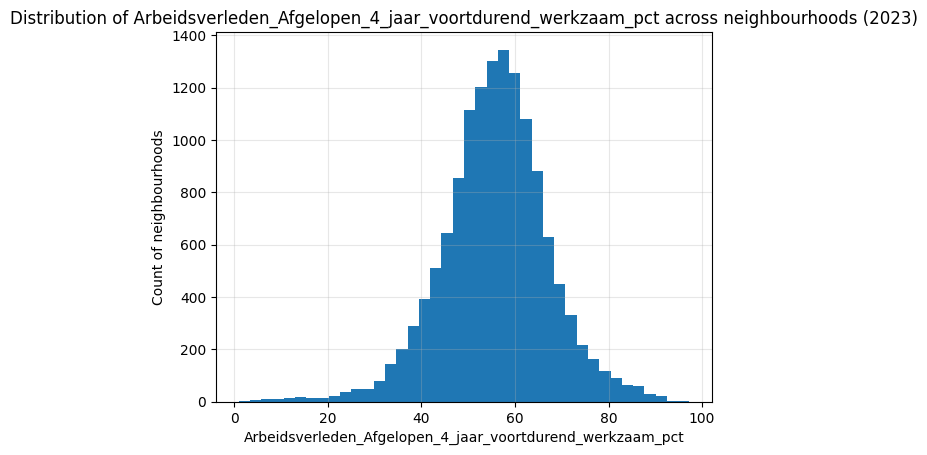

In [20]:
year_to_plot = int(2023)
example_indicator2 = numeric_cols[min(1, len(numeric_cols)-1)]

cross = wide[wide["year"] == year_to_plot][example_indicator2].dropna()

plt.figure()
plt.hist(cross, bins=40)
plt.title(f"Distribution of {example_indicator2} across neighbourhoods ({year_to_plot})")
plt.xlabel(example_indicator2)
plt.ylabel("Count of neighbourhoods")
plt.grid(True, alpha=0.3)
plt.show()
